# In this notebook I want to 
-create 256 X 256 data <br>
-create a UNET that works for this data <br>
-Train the model <br>
-Assess the results 

From what I did before Using 32X32 images, it seems that the network still tries to create signal out of noisy images. 

In [1]:
#Importing packages

## Importing important stuff
import random
import numpy as np
import pandas as pd
from PIL import Image 
import tifffile as tiff
             ###############
#plotting
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objs as go
            ####################


In [2]:
#machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical   
###
from keras import models
from keras import layers

#from __future__ import print_function
#import keras
from keras import backend as K
#import matplotlib
#from matplotlib import pyplot as plt
#import numpy as np
from keras.preprocessing.image import ImageDataGenerator
###
import pickle as pkl
import time

Using TensorFlow backend.


In [3]:
# reading the data 
df_good = pd.read_pickle("shuffled_good_df-Copy1.pkl")
df_bad=  pd.read_pickle("shuffled_bad_df-Copy1.pkl")
## making the pictures into numpy arrays, they are already shuffled so I can just split them as following. 
X = df_good.values #HSN images
y = df_bad.values  #LSN images


In [5]:
print(len(X))
print(len(y))

2300
2300


## Cropping

In [7]:

X_crop=[]
for sample in X:
    x_reshaped=sample.reshape(1200,1200)
    for i in range(1,4):
        for j in range(1,4):
            X_crop.append(x_reshaped[i*256:(i+1)*256, j*256:(j+1)*256])
            
y_crop=[]
for sample in y:
    y_reshaped=sample.reshape(1200,1200)
    for i in range(1,4):
        for j in range(1,4):
            y_crop.append(y_reshaped[i*256:(i+1)*256, j*256:(j+1)*256])

In [8]:
X_crop = np.asarray(X_crop)
y_crop  = np.asarray(y_crop)

In [9]:
print('shape of original bad images', X_crop.shape)
print('shape of original good images',y_crop.shape)

shape of original bad images (20700, 256, 256)
shape of original good images (20700, 256, 256)


In [10]:
#Saving them for future 
np.save('bd_orig_256.npy', X_crop, allow_pickle= True)
np.save('gd_orig_256.npy', y_crop, allow_pickle=True)

## Loading data

In [3]:
#loading the images 
X_crop = np.load('bd_orig_256.npy')
y_crop = np.load('gd_orig_256.npy')

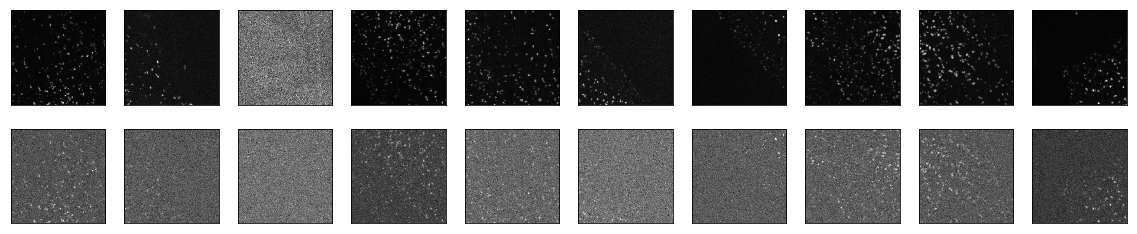

In [4]:
#checking correspondance 
#####check for correspondance
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_crop[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
        # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_crop[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Image generation

In [5]:
#defning the image generator 

datagen = ImageDataGenerator(featurewise_center=False, 
                             samplewise_center=False, 
                             featurewise_std_normalization=False, 
                             samplewise_std_normalization=False, 
                             zca_whitening=False, 
                             zca_epsilon=0, 
                             rotation_range=0, #rotating images by 90 degrees 
                             width_shift_range=0.0, 
                             height_shift_range=0.0, 
                             brightness_range=None, 
                             shear_range=0.0, 
                             zoom_range=0.0, 
                             channel_shift_range=0.0, 
                             fill_mode='nearest', 
                             cval=0.0, 
                             horizontal_flip=True, # flipping the image horizontally
                             vertical_flip=True,   #flipping the image vertically
                             rescale=None, 
                             preprocessing_function=None, 
                             data_format=None, validation_split=0.0, dtype=None)


In [6]:
#reshaping for image augmentation
X_tbaug  = X_crop.reshape(X_crop.shape[0], 256,256,1)
y_tbaug =  y_crop.reshape(y_crop.shape[0],256,256,1)

In [7]:
start= time.time()
batch_size=15000
x_aug=[]
i=0
for img_batch in datagen.flow(X_tbaug, batch_size=batch_size, seed=42):
    for img in img_batch:    
        im2=img.reshape(256,256)
        x_aug.append(im2)
        i=i+1    
    if i >= batch_size:
        break
        
x_aug = np.asarray(x_aug)


print('finished generating bad images')
print(' generated bad images shape', x_aug.shape)


y_aug=[]
i=0
for img_batch in datagen.flow(y_tbaug, batch_size=batch_size, seed=42):
    for img in img_batch:
        im2=img.reshape(256,256)
        y_aug.append(im2)
        i=i+1    
    if i >= batch_size:
        break
        
y_aug = np.asarray(y_aug)

print('finished generating good images')
print(' generated good images shape', y_aug.shape)

finished generating bad images
 generated bad images shape (15000, 256, 256)
finished generating good images
 generated good images shape (15000, 256, 256)


In [13]:
#Saving generated images 
np.save('bd_aug_256.npy', x_aug , allow_pickle = True)
np.save('gd_aug_256.npy', y_aug, allow_pickle = True)

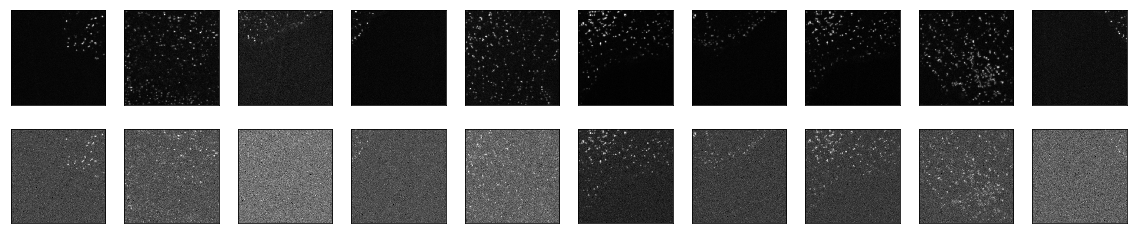

In [8]:
#checking correspondance 
#####check for correspondance
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_aug[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
        # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_aug[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [10]:
## Test train split
x_aug = x_aug.reshape(x_aug.shape[0],256,256)
y_aug = x_aug.reshape(y_aug.shape[0],256,256)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_aug, y_aug, test_size=0.2, random_state=42)

In [11]:
print('shape of X_train', X_train.shape)
print('shape of X_test', X_test.shape)
print('shape of y_train', y_train.shape)
print('shape of y_test', y_test.shape)

shape of X_train (12000, 256, 256)
shape of X_test (3000, 256, 256)
shape of y_train (12000, 256, 256)
shape of y_test (3000, 256, 256)


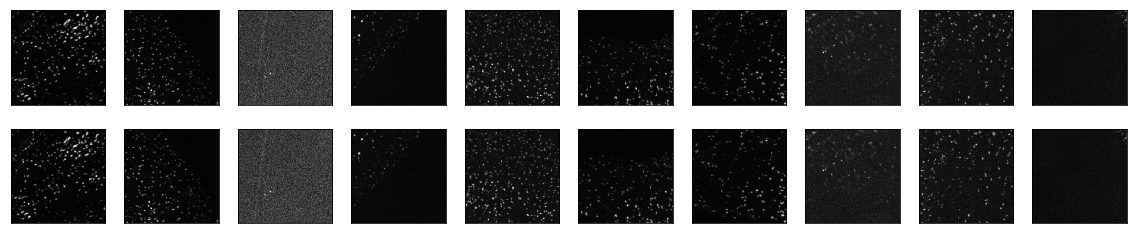

In [12]:
#Checking correspondance 
#checking correspondance 
#####check for correspondance
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
        # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_train[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Creating the network


In [2]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K

import os
import pickle
import numpy as np
#import cv2

Using TensorFlow backend.


In [3]:
inputs = Input((256, 256, 1)) # 256
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs) 
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) # 128 
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) # 64 
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)  # 32 
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv1)   #16
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
pool5 = MaxPooling2D(pool_size=(2, 2))(conv2)   #4
conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool5)
conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv6)
pool6 = MaxPooling2D(pool_size=(2, 2))(conv3)  #2
conv7 = Conv2D(2048, (3, 3), activation='relu', padding='same')(pool6)
conv7 = Conv2D(2048, (3, 3), activation='relu', padding='same')(conv7)
pool7 = MaxPooling2D(pool_size=(2, 2))(conv4)   #1
conv8 = Conv2D(4096, (3, 3), activation='relu', padding='same')(pool7)
conv8 = Conv2D(4096, (3, 3), activation='relu', padding='same')(conv8)


Instructions for updating:
Colocations handled automatically by placer.


In [4]:
encoder = Model(inputs=[inputs], outputs=[conv8])

In [5]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
__________

In [24]:
conv4.shape

TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(256)])

In [18]:
up9 = concatenate([Conv2DTranspose(2048, (2, 2), strides=(2, 2), padding='same')(conv8), conv7], axis=3)
conv9 = Conv2D(2048, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(2048, (3, 3), activation='relu', padding='same')(conv9)
#
up10 = concatenate([Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(conv9), conv6], axis=3)
conv10 = Conv2D(1024, (3, 3), activation='relu', padding='same')(up10)
conv10 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv10)
#
up11 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv10), conv5], axis=3)
conv11 = Conv2D(512, (3, 3), activation='relu', padding='same')(up11)
conv11 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv11)
#
up12 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv11), conv4], axis=3)
conv12 = Conv2D(256, (3, 3), activation='relu', padding='same')(up12)
conv12 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv12)
#
up13 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv12), conv3], axis=3)
conv13 = Conv2D(128, (3, 3), activation='relu', padding='same')(up13)
conv13 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv13)
#
up14 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv13), conv2], axis=3)
conv14 = Conv2D(64, (3, 3), activation='relu', padding='same')(up14)
conv14 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv14)
#
up15 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv14), conv1], axis=3)
conv15 = Conv2D(32, (3, 3), activation='relu', padding='same')(up14)
conv15 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv14)

#removed the activatio = 'sigmoid from the last layer'
conv16 = Conv2D(1, (3, 3), padding='same')(conv15)

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 256, 256, 256), (None, 32, 32, 256)]

In [ ]:
## another trial 

In [26]:
inputs = Input((256, 256, 1)) #256
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(4, 4))(conv1) #64
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(4, 4))(conv2) #16
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(4, 4))(conv3) #4 
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4) #2
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

In [27]:
up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)   #4
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6) 
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
up7 = concatenate([Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(conv6), conv3], axis=3)  #16
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
up8 = concatenate([Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(conv7), conv2], axis=3)    #64
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
up9 = concatenate([Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same')(conv8), conv1], axis=3)    #256
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
#removed the activatio = 'sigmoid from the last layer'
conv10 = Conv2D(1, (3, 3), padding='same')(conv9)

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 8, 8, 128), (None, 16, 16, 128)]